# Bibliotecas

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Dataframe dos resultados

In [2]:
path = "/home/lucas/experimentos/Test_Imports/version_1/metrics.csv"

df = pd.read_csv(path)
df

,loss,epoch,step,val_loss
0,1.647707e+06,0,49,NaN
1,1.156653e+06,0,99,NaN
2,8.189774e+05,0,149,NaN
3,NaN,0,188,5.661879e+05
4,6.506643e+05,1,199,NaN
...,...,...,...,...
243,1.153569e+10,51,9649,NaN
244,1.092115e+10,51,9699,NaN
245,1.004695e+10,51,9749,NaN
246,9.652037e+09,51,9799,NaN


# 2. Obtendo a loss de treino e de validacao

## 2.1 Validacao

In [3]:
#df_val_loss = df[df['val_loss'].apply(lambda x: pd.notna(x))].copy()
df_val_loss = df[["epoch","val_loss"]].copy()
df_val_loss.rename({"val_loss":"loss"},inplace=True,axis=1)
df_val_loss["Split"] = "Validação"

df_val_loss = df_val_loss[df_val_loss.loss.apply(lambda x: pd.notna(x))]
df_val_loss

,epoch,loss,Split
3,0,5.661879e+05,Validação
8,1,3.309670e+05,Validação
13,2,2.481904e+05,Validação
18,3,1.991000e+05,Validação
22,4,1.740248e+05,Validação
27,5,1.571344e+05,Validação
32,6,1.462149e+05,Validação
37,7,1.349018e+05,Validação
42,8,1.316699e+05,Validação
46,9,1.224383e+05,Validação


## 2.2 Treino

In [4]:
#index_val = df_val_loss.index.tolist()

#index_val = [x - 1 for x in index_val]
#df_train_loss = df.loc[index_val].copy()
df_train_loss = df[["epoch","loss"]].copy()

df_train_loss["Split"] = "Treino"
df_train_loss

,epoch,loss,Split
0,0,1.647707e+06,Treino
1,0,1.156653e+06,Treino
2,0,8.189774e+05,Treino
3,0,NaN,Treino
4,1,6.506643e+05,Treino
...,...,...,...
243,51,1.153569e+10,Treino
244,51,1.092115e+10,Treino
245,51,1.004695e+10,Treino
246,51,9.652037e+09,Treino


# 3. Grafico comparativo de Loss

In [5]:
df_concat = pd.concat([df_train_loss,df_val_loss])

<Axes: xlabel='epoch', ylabel='loss'>

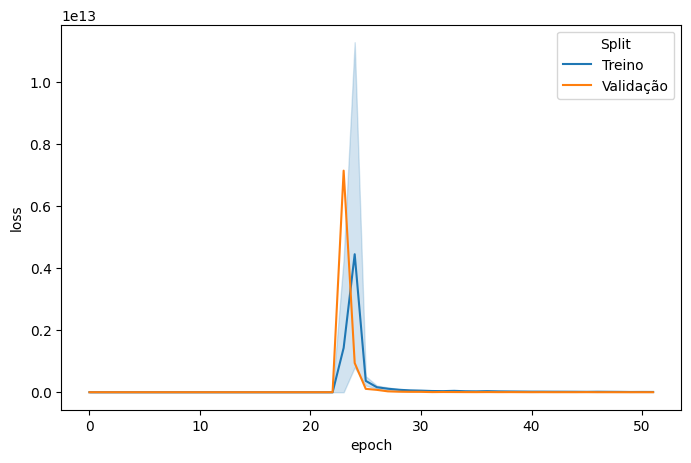

In [6]:
fig, ax = plt.subplots(figsize=(8,5))

sns.lineplot(data=df_concat,x="epoch",y="loss",hue="Split",ax=ax)

#sns.lineplot(data=df,x="epoch",y="loss",ax=ax)
#sns.lineplot(data=df,x="epoch",y="val_loss",ax=ax)

# 4. Load Model

In [11]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

import sys
sys.path.append("/home/lucas/Image-Denoising/src")


import pandas as pd
from PIL import Image
from tqdm import tqdm

from models import VisionModelTransformerTorchV2 as VisionModel
from noises import add_noise
from dataset import CustomImageDataset

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from modules.train_module import TrainModule
from torchvision.transforms import v2

from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch import Trainer

In [14]:
class AddNoise(torch.nn.Module):
    def forward(self, img, noise,**kwargs):
        noisy_image = add_noise(img, noise_type=noise,**kwargs)

        return Image.fromarray(noisy_image)

batch_size = 2
num_workers = 8
lr = 0.001

noise = AddNoise()
transform = v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True)
])

path = "/home/lucas/Image-Denoising/dataframes/dataframe_v1.csv"
df = pd.read_csv(path)

val = df[df["split"] == 'val']
train = df[df["split"] == 'train']

val_dataset = CustomImageDataset(val,transform,noise)
train_dataset = CustomImageDataset(train,transform,noise)


custom_dataloader_val = DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False)


custom_dataloader_train = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False)



model = VisionModel(img_size=(2,3,224,224), patch_size=14, token_len=512, embed_dim=512, num_heads=8, num_layers=6)

model = model.cpu()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

model = TrainModule.load_from_checkpoint(
    "/home/lucas/experimentos/Test_Imports/version_1/checkpoint-epoch=21-val_loss=91554.6640625000.ckpt",
    map_location={"cuda:0":"cpu","cuda:1":"cpu","cuda":"cpu"},
    model=model,
    loss=loss_fn,
    optim=optimizer
)

/home/lucas/miniconda3/envs/image-denoising/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


# 5 Testando inferencias

In [32]:
i = 0
stop = 4
for ori_img, noi_img in custom_dataloader_val:
    if(i == stop):
        break
    i+=1

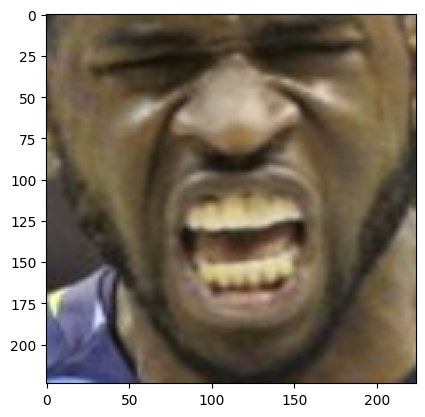

In [33]:
plt.imshow(ori_img[1].permute(1,2,0).detach().numpy())

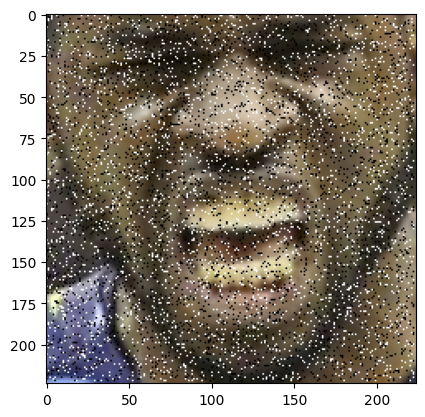

In [34]:
plt.imshow(noi_img[1].permute(1,2,0).detach().numpy())

In [35]:
denoised = model.model(noi_img)

In [36]:
from models.tokenization import UnPatchTokenizationEinops

In [37]:
un_patch = UnPatchTokenizationEinops(14,224)

In [38]:
denoised = un_patch(denoised)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15552497..1.052771].


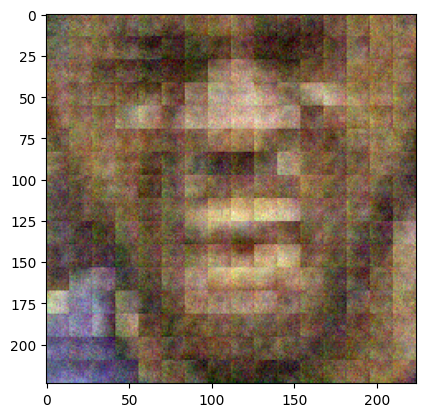

In [39]:
plt.imshow(denoised[1].permute(1,2,0).detach().numpy())

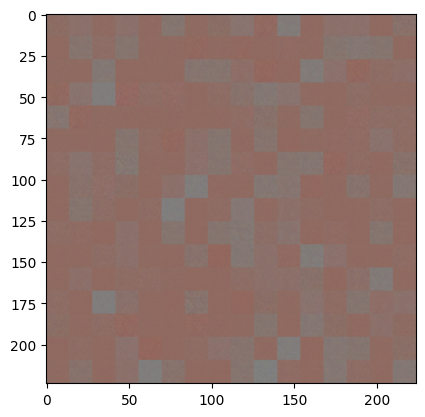

In [15]:
denoised_ = model.model.unpatch_tokenization(denoised[:,:-1,:])
plt.imshow(denoised_[0].permute(1,2,0).detach().numpy())

In [19]:
ori_img_ = model.model.patch_tokenization(ori_img)
denoised_ = model.model.patch_tokenization(denoised_)

In [20]:
denoised_.shape

torch.Size([2, 256, 512])

In [21]:
ori_img_.shape

torch.Size([2, 256, 512])

In [22]:
loss = nn.MSELoss(reduction='none')
loss = loss(denoised_,ori_img_)

In [27]:
torch.sum(loss,dim=-1).sum()

tensor(0.2339, grad_fn=<SumBackward0>)

In [41]:
torch.sum(loss,dim=-1).sum()/2

tensor(0.0484, grad_fn=<DivBackward0>)

In [33]:
denoised.shape

torch.Size([2, 257, 588])

In [55]:

#ori_img_ = model.model.linear(ori_img_)

In [56]:
ori_img_.shape

torch.Size([2, 256, 512])

In [58]:
denoised_.shape

torch.Size([2, 3, 224, 224])

In [59]:
denoised_ = model.model.patch_tokenization(denoised_)
denoised_.shape

torch.Size([2, 256, 512])

In [60]:
loss = nn.MSELoss(reduction='none')
loss = loss(denoised_,ori_img_)

In [61]:
loss.sum(dim=1).mean()

tensor(0.0006, grad_fn=<MeanBackward0>)

In [82]:
torch.mean(loss,dim=1).sum(dim=1).mean()

tensor(0.9580, grad_fn=<MeanBackward0>)

In [75]:
((ori_img_ - denoised_)**2).sum(dim=1).mean()

tensor(0.4790, grad_fn=<MeanBackward0>)

In [52]:
denoised[0].shape

torch.Size([3, 224, 224])

In [48]:
(ori_img[0] - noi_img[0]).sum(dim=1).mean()

tensor(3.4154)

In [50]:
loss = nn.MSELoss()

In [64]:
loss(denoised[:,:-1,:],ori_img_)

tensor(3.8718e-05, grad_fn=<MseLossBackward0>)

In [17]:
denoised_.shape

torch.Size([2, 3, 224, 224])

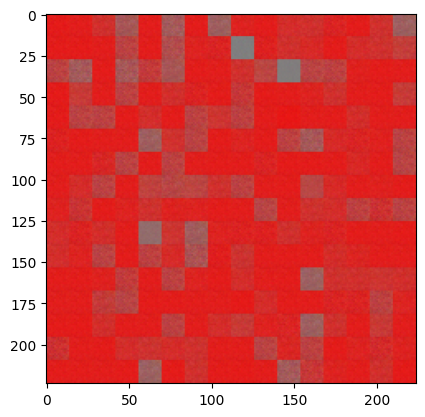

In [36]:
plt.imshow(denoised_[0].permute(1,2,0).detach().numpy())